In [ ]:
!pip install tensorflow-probability

# to generate gifs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

In [3]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

### Carrega o dataset

### Ordenando Dataset com Imagens e Condicionantes

In [4]:
import tensorflow as tf
import os
from glob import glob
import pandas as pd
import numpy as np

# Caminho das imagens
data_dir = "/kaggle/input/celeba/img_align_celeba/img_align_celeba/"
image_paths = sorted(glob(os.path.join(data_dir, "*.jpg")))

# Carrega os atributos
attr_df = pd.read_csv(
    "/kaggle/input/celeba/list_attr_celeba.txt",
    sep='\s+',  # ou sep='\s+'
    skiprows=1  # pula a linha que tem só o número de imagens
)
attr_df.index.name = "image_id"
attr_df.reset_index(inplace=True)  # coloca 'image_id' como coluna

attr_df = attr_df[attr_df['image_id'].isin([os.path.basename(p) for p in image_paths])]
attr_df = attr_df.sort_values('image_id')  # Garante a ordem

# Filtra atributos desejados
selected_attrs = ['Smiling', 'Male', 'Blond_Hair', 'Eyeglasses', 'Wearing_Hat']
attr_df[selected_attrs] = (attr_df[selected_attrs] == 1).astype(np.float32)

# Cria arrays finais
image_paths = np.array(image_paths)
labels = attr_df[selected_attrs].values  # já ordenado igual às imagens

# TF Dataset com (imagem, label)
def preprocess_pair(img_path, label):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [64, 64])
    image = image / 255.0
    return image, label

dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
dataset = dataset.map(preprocess_pair, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size=10000)
dataset = dataset.batch(32)
dataset = dataset.prefetch(tf.data.AUTOTUNE)


I0000 00:00:1751244922.174588     239 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751244922.175283     239 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


### Separando o dataset de treino e o dataset de validação

In [5]:
# Número total de amostras
total_samples = len(image_paths)
val_split = 0.2
val_size = int(total_samples * val_split)
train_size = total_samples - val_size

# Dataset sem batching nem shuffle ainda (pra controle)
base_dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
base_dataset = base_dataset.map(preprocess_pair, num_parallel_calls=tf.data.AUTOTUNE)

# Divide
train_dataset = base_dataset.take(train_size).shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = base_dataset.skip(train_size).batch(32).prefetch(tf.data.AUTOTUNE)


In [6]:
test_size = val_size

In [7]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [8]:
batch_size = 32

### cCVAE Modelo

In [9]:
class cCVAE(tf.keras.Model):
    def __init__(self, latent_dim, cond_dim=5):
        super(cCVAE, self).__init__()
        self.latent_dim = latent_dim
        self.cond_dim = cond_dim

        # Encoder
        self.encoder_net = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(64, 64, 3)),
            tf.keras.layers.Conv2D(32, 4, strides=2, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(0.2),
            tf.keras.layers.Dropout(0.3),

            tf.keras.layers.Conv2D(64, 4, strides=2, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(0.2),
            tf.keras.layers.Dropout(0.1),

            tf.keras.layers.Conv2D(128, 4, strides=2, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(0.2),
            tf.keras.layers.Dropout(0.1),

            tf.keras.layers.Conv2D(256, 4, strides=2, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(0.2),
            tf.keras.layers.Dropout(0.05),

            tf.keras.layers.Flatten()
        ], name='encoder_net')

        self.encoder_fc = tf.keras.layers.Dense(
                self.latent_dim * 2,
                name="encoder_fc"
            )
        self.cond_proj_layer = tf.keras.layers.Dense(4096, name="cond_proj_layer")

        # Decoder
        self.decoder_net = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim + cond_dim,)),
            tf.keras.layers.Dense(4*4*128, activation='relu'),
            tf.keras.layers.Reshape((4, 4, 128)),

            tf.keras.layers.Conv2DTranspose(128, 4, strides=2, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(0.2),

            tf.keras.layers.Conv2DTranspose(64, 4, strides=2, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(0.2),

            tf.keras.layers.Conv2DTranspose(32, 4, strides=2, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(0.2),

            tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same')  # logits
        ], name='decoder_net')

    def encode(self, x, cond):
        x_encoded = self.encoder_net(x)  # shape (batch, 4096)
        cond_proj = self.cond_proj_layer(cond)  # shape (batch, 4096)
        x_cond = tf.concat([x_encoded, cond_proj], axis=-1)
        mean_logvar = self.encoder_fc(x_cond)
        mean, logvar = tf.split(mean_logvar, num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(0.5 * logvar) + mean

    def decode(self, z, cond, apply_sigmoid=False):
        z_cond = tf.concat([z, cond], axis=1)
        x_logit = self.decoder_net(z_cond)
        return tf.sigmoid(x_logit) if apply_sigmoid else x_logit

    @tf.function
    def sample(self, cond, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(cond.shape[0], self.latent_dim))
        return self.decode(eps, cond, apply_sigmoid=True)


In [15]:
model = cCVAE(512)

# Exemplo: pegar batch e passar por encode-decode
for x,cond in train_dataset.take(1):
    mean, logvar = model.encode(x, cond)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z, cond)
    print("Reconstrução:", x_logit.shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1751245080.511471     239 cuda_dnn.cc:529] Loaded cuDNN version 90300


Reconstrução: (32, 64, 64, 3)


## Treino do Modelo

In [10]:
def compute_beta(epoch, total_epochs, max_beta=1.0):
    # Cresce linearmente do 0 ao 1
    return min(max_beta, epoch / (total_epochs * 0.3))

### Compute Losses

In [11]:
train_loss_list = []
kl_loss_list = []
recon_loss_list = []

### Save Reconstructions

In [12]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

def save_reconstructions(model, dataset, epoch, save_dir='/kaggle/working/reconstructions/'):
    os.makedirs(save_dir, exist_ok=True)

    for batch in dataset.take(1):
        # Supondo que batch = (x, cond)
        x, cond = batch
        cond = tf.cast(cond, tf.float32)
        x = tf.cast(x, tf.float32)

        z_mean, z_log_var = model.encode(x, cond)
        z = model.reparameterize(z_mean, z_log_var)
        x_logit = model.decode(z, cond)
        x_recon = tf.sigmoid(x_logit)

        n = min(8, x.shape[0])
        plt.figure(figsize=(16, 4))
        for i in range(n):
            # Imagem original
            plt.subplot(2, n, i + 1)
            plt.imshow(x[i].numpy())
            plt.axis('off')
            if i == 0:
                plt.title('Original')

            # Imagem reconstruída
            plt.subplot(2, n, i + 1 + n)
            plt.imshow(x_recon[i].numpy())
            plt.axis('off')
            if i == 0:
                plt.title('Reconstruída')

        plt.suptitle(f'Época {epoch}')
        plt.savefig(os.path.join(save_dir, f'reconstruction_epoch_{epoch}.png'))
        plt.close()


### Optimizer

In [13]:
optimizer = tf.keras.optimizers.Adam(1e-4)

### Save Checkpoints

In [24]:
import os
import tensorflow as tf
from datetime import datetime

# Diretórios
base_dir = '/kaggle/working/'
checkpoint_dir = os.path.join(base_dir, 'checkpoints')
saved_models_dir = os.path.join(base_dir, 'saved_models')

os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(saved_models_dir, exist_ok=True)

# Objeto de checkpoint
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

def save_checkpoint():
    # Timestamp para nomear diretórios e evitar conflitos
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

    # === 1. Salva o checkpoint (pesos e estado do otimizador) ===
    checkpoint_prefix = os.path.join(checkpoint_dir, f"ckpt-{timestamp}")
    checkpoint_path = checkpoint.save(file_prefix=checkpoint_prefix)
    print(f"💾 Checkpoint salvo em: {checkpoint_path}")

    # === 2. Salva o modelo completo (estrutura + pesos) ===
    model_path = os.path.join(saved_models_dir, f"model-{timestamp}.h5")
    model.save(model_path)
    print(f"✅ Modelo completo salvo em: {model_path}")


### Loss

In [17]:
import tensorflow as tf
import tensorflow.keras.losses as losses

def compute_loss(model, x, cond, beta):
    mean, logvar = model.encode(x, cond)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z, cond)

    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
    # soma por pixel (altura, largura, canais)
    reconstruction_loss = tf.reduce_sum(bce(x, x_logit), axis=[1, 2])

    kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=1)

    total_loss = tf.reduce_mean(reconstruction_loss + beta * kl_loss)
    return total_loss, reconstruction_loss, kl_loss


### Train Functions :)

In [18]:
import shutil

In [ ]:
ckp_ulltimo_70 = 15

def zip_checkpoint(ckp_ulltimo_70):
    ckp_ulltimo_70 += 1
    prefix = f"/kaggle/working/checkpoints/ckpt-{ckp_ulltimo_70}"
    zip_path = f"/kaggle/working/last_ckpt_{epoch}.zip"
    cmd = [
        "zip", "-j", zip_path,
        f"{prefix}.index",
        f"{prefix}.data-00000-of-00001"
    ]
    subprocess.run(cmd)
    return ckp_ulltimo_70

In [19]:
@tf.function
def train_step(model, x, cond, beta):
    x = tf.cast(x, tf.float32)
    with tf.GradientTape() as tape:
        loss, reconstruction_loss, kl_loss = compute_loss(model, x, cond, beta)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, kl_loss, reconstruction_loss


def train(model, dataset, epochs):
    for epoch in range(1, epochs + 1):
        total_loss = 0
        total_kl = 0
        total_recon = 0
        num_batches = 0

        for batch in dataset:
            # supondo que o batch é tupla (x, cond)
            x, cond = batch
            #print("Shape do x no batch:", x.shape)
            #print("Shape do cond no batch:", cond.shape)
            beta = compute_beta(epoch, total_epochs=epochs)
            loss, kl_loss, recon_loss = train_step(model, x, cond, beta)
            total_loss += tf.reduce_mean(loss)
            total_kl += tf.reduce_mean(kl_loss)
            total_recon += tf.reduce_mean(recon_loss)
            num_batches += 1

        avg_loss = total_loss / num_batches
        avg_kl = total_kl / num_batches
        avg_recon = total_recon / num_batches

        train_loss_list.append(avg_loss.numpy())
        kl_loss_list.append(avg_kl.numpy())
        recon_loss_list.append(avg_recon.numpy())

        tf.print("Época", epoch,
                 "Loss:", avg_loss,
                 "KL:", np.mean(kl_loss_list),
                 "Recon:", np.mean(recon_loss_list))

        if epoch % 5 == 0 or epoch == 1:
            save_reconstructions(model, val_dataset, epoch)
            save_checkpoint()
            # Cria um .zip com os arquivos do checkpoint
            #ckp_ulltimo_70 = zip_checkpoint(ckp_ulltimo_70)
            #shutil.make_archive(f"/kaggle/working/checkpoints_til_{epoch}_ccvae", 'zip', checkpoint_dir)

## Executando

In [21]:
latent_dim = 512
model = cCVAE(latent_dim)

In [22]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [25]:
train(model, train_dataset, epochs=70)

Época 1 Loss: 2065.63257 KL: 413.3504 Recon: 2085.4092
💾 Checkpoint salvo em: /kaggle/working/checkpoints/ckpt-20250630-011634-1
✅ Modelo completo salvo em: /kaggle/working/saved_models/model-20250630-011634.h5
Época 2 Loss: 2064.15454 KL: 375.18604 Recon: 2068.8354
Época 3 Loss: 2066.3894 KL: 340.8667 Recon: 2059.7266
Época 4 Loss: 2070.22974 KL: 313.33472 Recon: 2054.0857
Época 5 Loss: 2074.66138 KL: 291.0546 Recon: 2050.3857
💾 Checkpoint salvo em: /kaggle/working/checkpoints/ckpt-20250630-012304-2
✅ Modelo completo salvo em: /kaggle/working/saved_models/model-20250630-012304.h5
Época 6 Loss: 2079.37427 KL: 272.54843 Recon: 2047.9352
Época 7 Loss: 2084.13525 KL: 256.8172 Recon: 2046.3479
Época 8 Loss: 2088.75708 KL: 243.1989 Recon: 2045.3783
Época 9 Loss: 2093.11304 KL: 231.25359 Recon: 2044.8486
Época 10 Loss: 2097.25 KL: 220.66617 Recon: 2044.6427
💾 Checkpoint salvo em: /kaggle/working/checkpoints/ckpt-20250630-013031-3
✅ Modelo completo salvo em: /kaggle/working/saved_models/model

In [26]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image

# Mapeamento das condições
selected_attrs = ["Smiling", "Male", "Blond_Hair", "Eyeglasses", "Wearing_Hat"]
attr2idx = {attr: idx for idx, attr in enumerate(selected_attrs)}

def generate_and_save_images(model, condition_name, is_yes, num_images, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Vetor condicional para o batch inteiro
    cond_vector = np.zeros((num_images, len(selected_attrs)), dtype=np.float32)
    if is_yes:
        cond_vector[:, attr2idx[condition_name]] = 1.0

    # Amostragem do vetor z
    z = tf.random.normal(shape=(num_images, model.latent_dim))

    # Geração das imagens
    generated_images = model.decode(z, cond_vector)
    generated_images = tf.clip_by_value((generated_images + 1.0) / 2.0, 0.0, 1.0)  # [-1,1] → [0,1]

    # Salva cada imagem no formato sample_01.jpg, sample_02.jpg, ...
    for i in range(num_images):
        img_array = (generated_images[i].numpy() * 255).astype(np.uint8)
        img = Image.fromarray(img_array)
        filename = f"sample_{i+1:02d}.jpg"
        img.save(os.path.join(output_dir, filename))


In [30]:
model_name = "CVAE"  # ou "VAE", "GAN", "Diffuser"

base_output_dir = f"/kaggle/working/generated_images/{model_name}"

for condition in selected_attrs:
    for is_yes in [True, False]:
        yes_no = "yes" if is_yes else "no"
        output_path = os.path.join(base_output_dir, condition.lower(), yes_no)
        generate_and_save_images(model, condition, is_yes, num_images=10, output_dir=output_path)


In [31]:
import shutil

def zip_generated_images(model_name="CVAE"):
    folder_to_zip = f"/kaggle/working/generated_images/{model_name}"
    zip_path = f"/kaggle/working/{model_name}_generated_images.zip"
    shutil.make_archive(zip_path.replace(".zip", ""), 'zip', folder_to_zip)
    print(f"Arquivo zip salvo em: {zip_path}")

zip_generated_images("CVAE")  # Ou "VAE", "GAN", "Diffuser"

Arquivo zip salvo em: /kaggle/working/CVAE_generated_images.zip


In [32]:
!zip -r recon.zip /kaggle/working/reconstructions/


  adding: kaggle/working/reconstructions/ (stored 0%)
  adding: kaggle/working/reconstructions/reconstruction_epoch_45.png (deflated 1%)
  adding: kaggle/working/reconstructions/reconstruction_epoch_20.png (deflated 1%)
  adding: kaggle/working/reconstructions/reconstruction_epoch_70.png (deflated 1%)
  adding: kaggle/working/reconstructions/reconstruction_epoch_50.png (deflated 1%)
  adding: kaggle/working/reconstructions/reconstruction_epoch_65.png (deflated 1%)
  adding: kaggle/working/reconstructions/reconstruction_epoch_15.png (deflated 1%)
  adding: kaggle/working/reconstructions/reconstruction_epoch_35.png (deflated 1%)
  adding: kaggle/working/reconstructions/reconstruction_epoch_1.png (deflated 1%)
  adding: kaggle/working/reconstructions/reconstruction_epoch_10.png (deflated 1%)
  adding: kaggle/working/reconstructions/reconstruction_epoch_30.png (deflated 1%)
  adding: kaggle/working/reconstructions/reconstruction_epoch_40.png (deflated 1%)
  adding: kaggle/working/reconstru

In [33]:
!zip -r models.zip /kaggle/working/saved_models/


  adding: kaggle/working/saved_models/ (stored 0%)
  adding: kaggle/working/saved_models/model-20250630-014519.h5 (deflated 7%)
  adding: kaggle/working/saved_models/model-20250630-025734.h5 (deflated 7%)
  adding: kaggle/working/saved_models/model-20250630-020653.h5 (deflated 7%)
  adding: kaggle/working/saved_models/model-20250630-024956.h5 (deflated 7%)
  adding: kaggle/working/saved_models/model-20250630-015245.h5 (deflated 7%)
  adding: kaggle/working/saved_models/model-20250630-015949.h5 (deflated 7%)
  adding: kaggle/working/saved_models/model-20250630-012304.h5 (deflated 8%)
  adding: kaggle/working/saved_models/model-20250630-013747.h5 (deflated 7%)
  adding: kaggle/working/saved_models/model-20250630-022811.h5 (deflated 7%)
  adding: kaggle/working/saved_models/model-20250630-023538.h5 (deflated 7%)
  adding: kaggle/working/saved_models/model-20250630-024244.h5 (deflated 7%)
  adding: kaggle/working/saved_models/model-20250630-011634.h5 (deflated 8%)
  adding: kaggle/working/

### Mais geração

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def generate_fixed_condition_images(model, condition_idx, condition_value=1, num_images=10):
    z = tf.random.normal(shape=(num_images, model.latent_dim))
    
    cond_vectors = np.zeros((num_images, len(selected_attrs)), dtype=np.float32)
    cond_vectors[:, condition_idx] = condition_value  # fixa a condição escolhida
    
    generated_images = model.decode(z, cond_vectors).numpy()
    
    # Reescala para [0,1]
    generated_images = (generated_images * 0.5) + 0.5
    
    for i in range(num_images):
        plt.imshow(generated_images[i])
        plt.axis('off')
        plt.title(f"{selected_attrs[condition_idx]} = {condition_value}")
        plt.show()


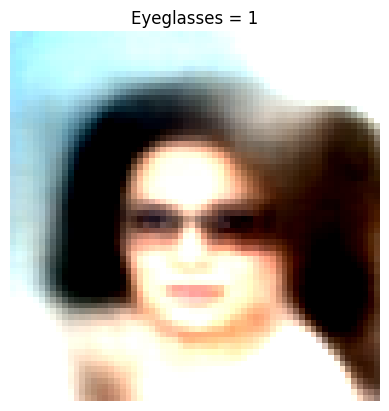

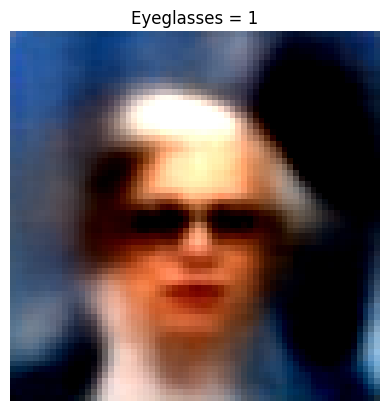

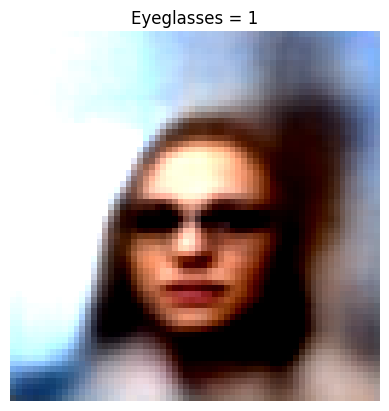

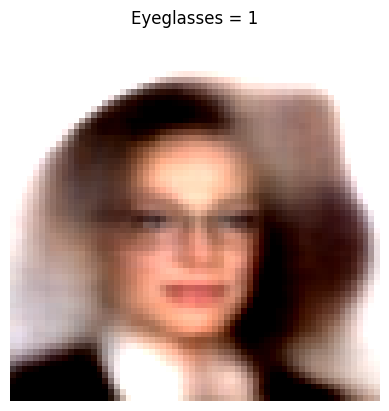

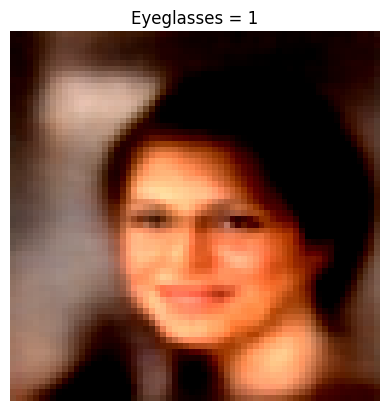

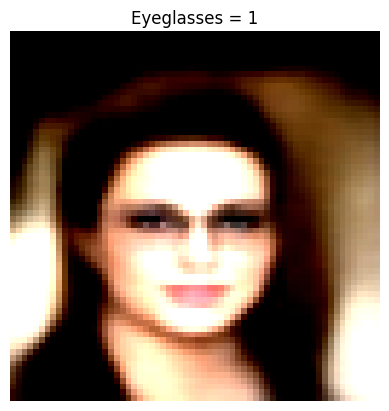

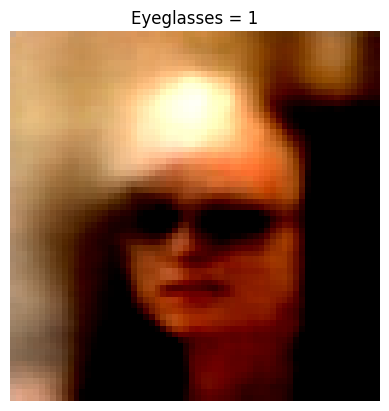

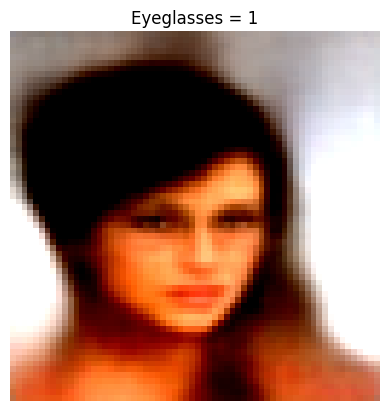

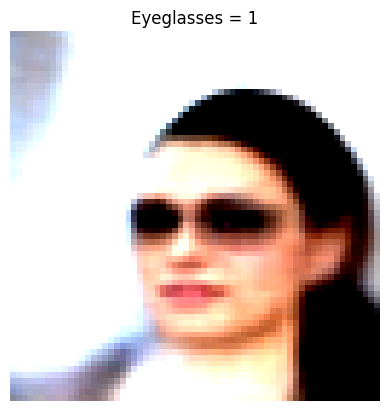

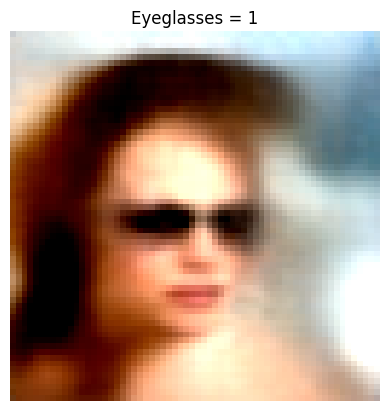

In [54]:
generate_fixed_condition_images(model,3)

### Gerando Imagens com condicionantes & o Loss | cCVAE-70epochs

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def sample_conditional_images(model, num_images=8):
    # Amostragem de vetores latentes z
    z = tf.random.normal(shape=(num_images, model.latent_dim))

    # Gera combinações de condicionantes (ex: sorrindo, homem, etc)
    cond_vectors = []
    for i in range(num_images):
        cond = np.zeros((len(selected_attrs),), dtype=np.float32)

        # Exemplo: alterna valores para visualização
        cond[0] = i % 2  # Smiling
        cond[1] = (i // 2) % 2  # Male
        cond[2] = (i // 4) % 2  # Blond_Hair
        cond[3] = (i // 8) % 2  # Eyeglasses
        cond[4] = (i // 16) % 2  # Wearing_Hat

        cond_vectors.append(cond)

    cond_vectors = np.stack(cond_vectors)

    # Gera imagens a partir de z e cond
    generated_images = model.decode(z, cond_vectors)

    # Plot
    plt.figure(figsize=(16, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow((generated_images[i].numpy() * 0.5 + 0.5))  # Reescala para [0,1]
        plt.axis('off')
    plt.suptitle("Geração Condicional")
    plt.show()


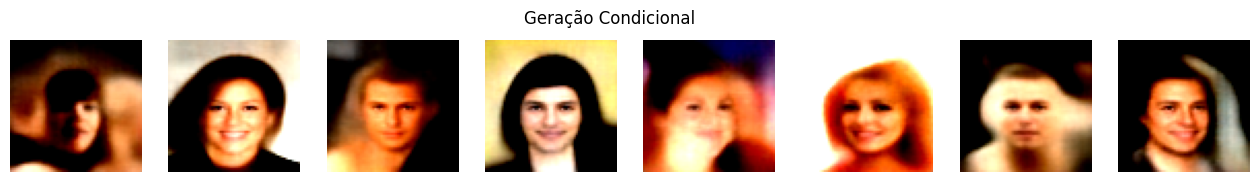

In [35]:
sample_conditional_images(model)

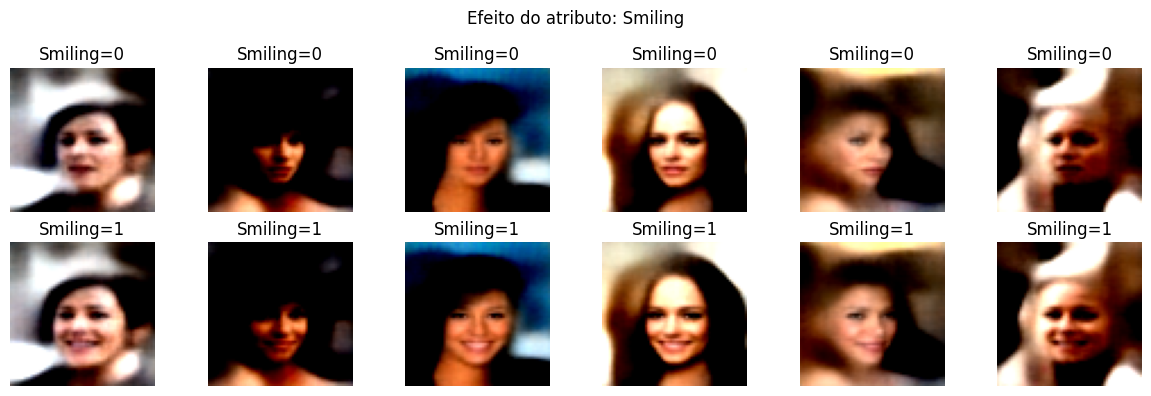

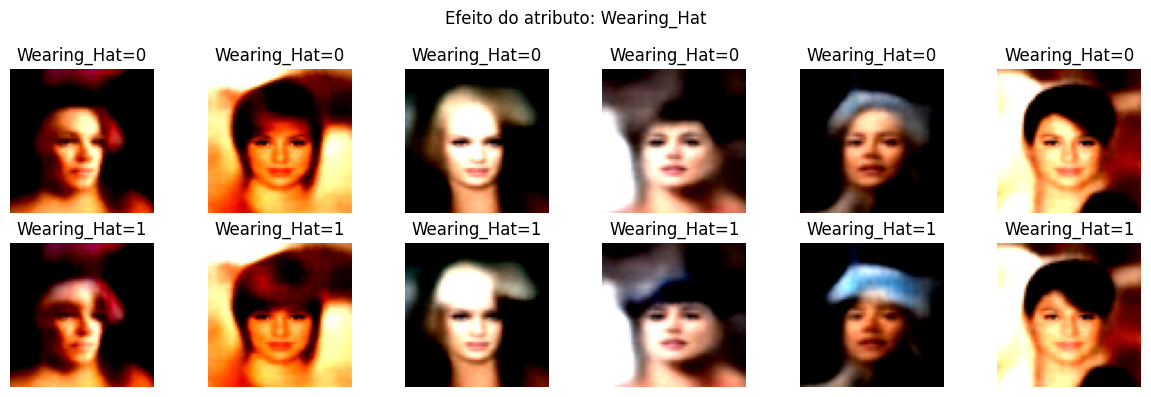

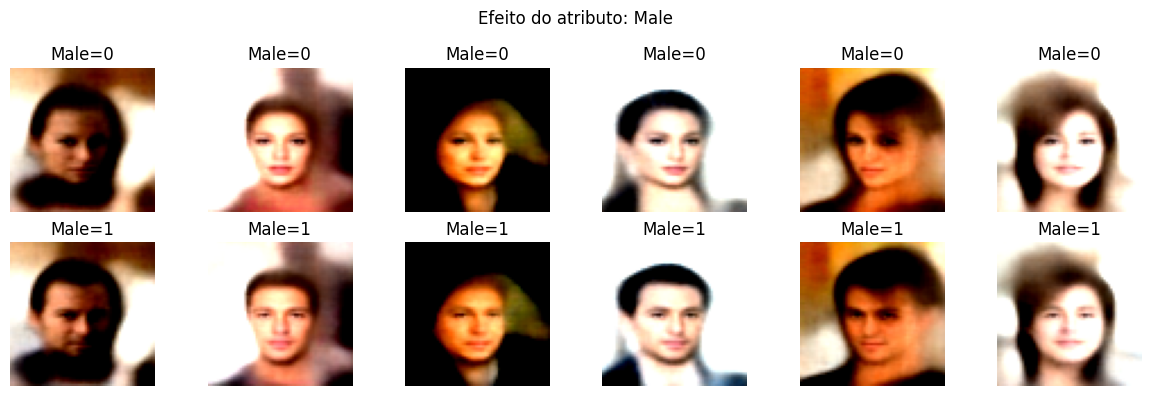

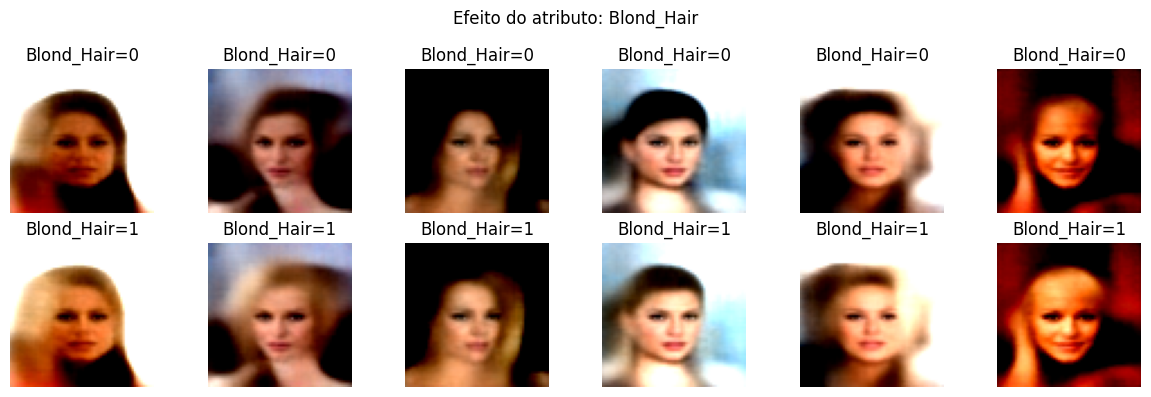

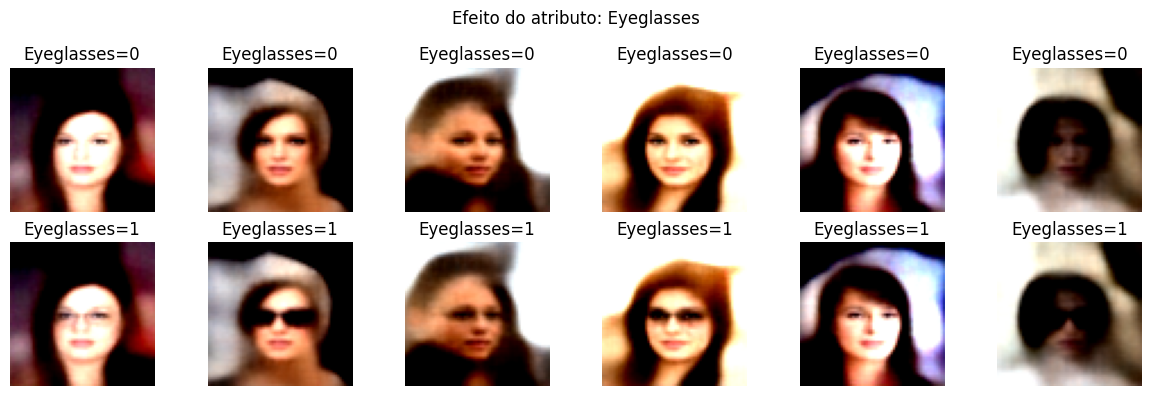

In [48]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

def gerar_grade_condicional(model, attr_index, attr_name, latent_dim, num_samples=6):
    plt.figure(figsize=(num_samples * 2, 4))
    
    for i in range(num_samples):
        z = tf.random.normal((1, latent_dim))

        for j, attr_value in enumerate([0, 1]):
            # Condições: todas zeradas, exceto a que estamos testando
            cond = np.zeros((1, 5), dtype=np.float32)
            cond[0, attr_index] = attr_value

            # Gera imagem
            img = model.decode(z, cond).numpy()[0]

            plt.subplot(2, num_samples, i + 1 + j * num_samples)
            plt.imshow((img * 0.5 + 0.5))  # Se tu normalizou em [-1, 1]
            plt.axis('off')
            if j == 0:
                plt.title(f"{attr_name}=0")
            else:
                plt.title(f"{attr_name}=1")

    plt.suptitle(f"Efeito do atributo: {attr_name}")
    plt.tight_layout()
    plt.savefig(f'/kaggle/working/geracao_condicional_{attr_name}')
    plt.show()

# Smiling = índice 0, Hat = índice 4
#selected_attrs = ['Smiling', 'Male', 'Blond_Hair', 'Eyeglasses', 'Wearing_Hat']

gerar_grade_condicional(model, attr_index=0, attr_name="Smiling", latent_dim=model.latent_dim)
gerar_grade_condicional(model, attr_index=4, attr_name="Wearing_Hat", latent_dim=model.latent_dim)
gerar_grade_condicional(model, attr_index=1, attr_name="Male", latent_dim=model.latent_dim)
gerar_grade_condicional(model, attr_index=2, attr_name="Blond_Hair", latent_dim=model.latent_dim)
gerar_grade_condicional(model, attr_index=3, attr_name="Eyeglasses", latent_dim=model.latent_dim)

In [46]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, kl_losses, recon_losses):
    epochs = range(1, len(train_losses) + 1)

    fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

    axs[0].plot(epochs, train_losses, color='purple')
    axs[0].set_title('Total Loss')
    axs[0].set_ylabel('Loss')
    axs[0].grid(True)

    axs[1].plot(epochs, kl_losses, color='green')
    axs[1].set_title('KL Divergence')
    axs[1].set_ylabel('KL')
    axs[1].grid(True)

    axs[2].plot(epochs, recon_losses, color='orange')
    axs[2].set_title('Reconstruction Loss')
    axs[2].set_ylabel('Recon')
    axs[2].set_xlabel('Época')
    axs[2].grid(True)

    plt.suptitle('Evolução das Losses por Época', fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('/kaggle/working/losses_cvae_70k.png')
    plt.show()


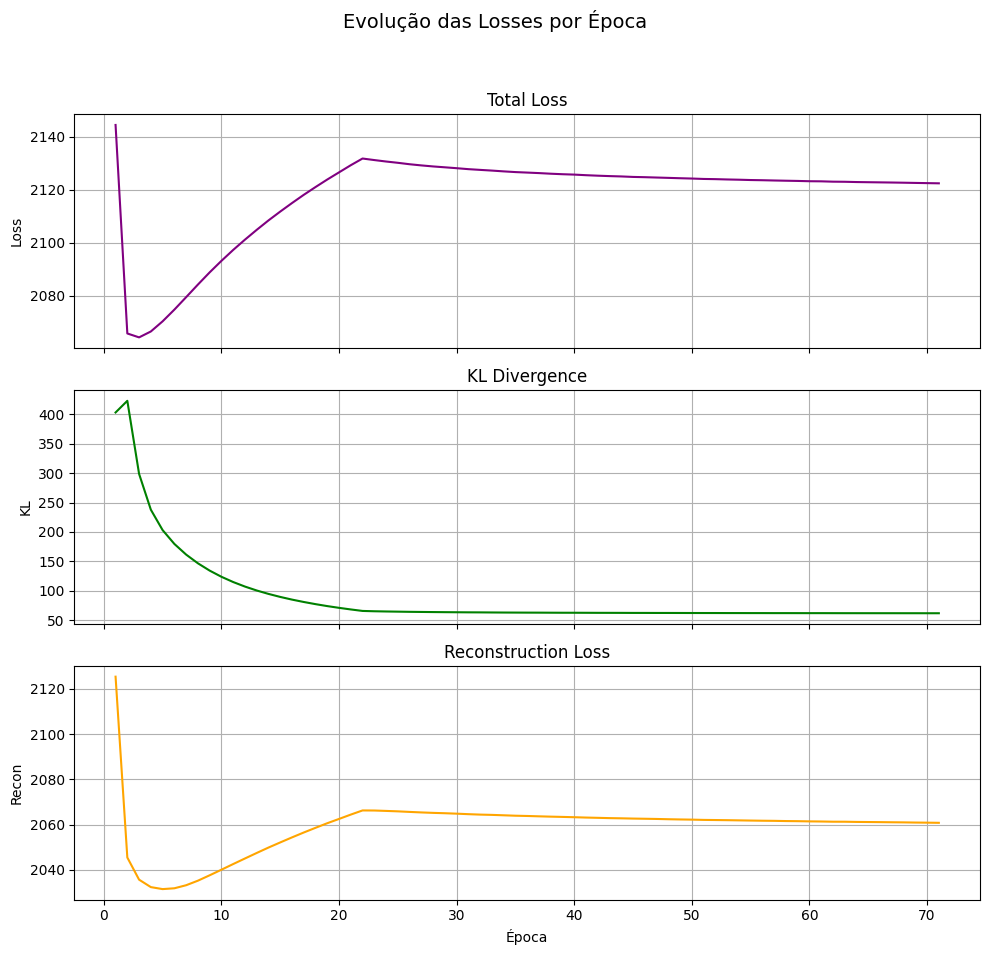

In [47]:

plot_losses(train_loss_list, kl_loss_list, recon_loss_list)

### Recuperando o CheckPoint

In [ ]:
# 1. Recria o modelo e otimizador com a mesma configuração
model = cCVAE(latent_dim=256)  # ou o valor que tu usou
optimizer = tf.keras.optimizers.Adam(1e-4)

# 2. Cria o objeto de checkpoint
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)


# 3. Faz o restore apontando diretamente pro caminho sem extensão
checkpoint_path = "/kaggle/input/ckp-ccvae/ckpt-15"
checkpoint.restore(checkpoint_path).assert_existing_objects_matched()  # ou .assert_existing_objects_matched()

print("✅ Checkpoint restaurado com sucesso!")


In [ ]:
model.summary() #input: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [ ]:
model.encoder_net.summary()

In [ ]:
model.decoder_net.summary()

In [ ]:
for var in model.trainable_variables:
    print(f"{var.name}: mean={tf.reduce_mean(var).numpy():.4f}, std={tf.math.reduce_std(var).numpy():.4f}")


In [ ]:
latent_dim = 512
model = cCVAE(latent_dim)

for x, cond in train_dataset.take(1):
    mean, logvar = model.encode(x, cond)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z, cond)
    print("Reconstrução:", x_logit.shape)


In [ ]:
show_images(x_logit,1)

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

num_images = 8
latent_dim = 512
cond_dim = 5  # número de atributos condicionantes

# Amostra z da normal padrão
z_sample = tf.random.normal(shape=(num_images, latent_dim))

# Define condições, ex: todos sorrindo e sem chapéu
cond_sample = tf.constant([[1, 0, 0, 0, 0]] * num_images, dtype=tf.float32)

# Gera imagens
generated_images = model.decode(z_sample, cond_sample)


In [ ]:

plt.figure(figsize=(16, 4))
num_images = generated_images.shape[0]

for i in range(num_images):
    img_sigmoid = tf.sigmoid(generated_images[i])  # Agora em [0,1]
    img = tf.squeeze(generated_images, axis=0)  # shape (64,64,3)
    img_sigmoid = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img))
    # Converte para numpy para matplotlib
    img_np = img_sigmoid.numpy()
    
    plt.subplot(1, num_images, i + 1)
    plt.imshow(img_np)
    plt.axis('off')

plt.suptitle("Imagens Geradas - após sigmoid")
plt.show()

In [ ]:
sample_conditional_images(model)

## Treino com data_augmented | cCVAE_70epochs_30epochsDA